In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy
import math
import scipy
import skimage
from sklearn import svm

In [6]:
def grad_rgb(im):
    dxR = scipy.ndimage.convolve1d(np.int32(im[:, :, 0]), np.array([-1, 0, 1]), 1)
    dyR = scipy.ndimage.convolve1d(np.int32(im[:, :, 0]), np.array([-1, 0, 1]), 0)
    gradR = np.sqrt(dxR ** 2 + dyR ** 2) / np.amax(np.sqrt(dxR ** 2 + dyR ** 2))
    orientR = np.arctan2(dyR, dxR)

    dxG = scipy.ndimage.convolve1d(np.int32(im[:, :, 1]), np.array([-1, 0, 1]), 1)
    dyG = scipy.ndimage.convolve1d(np.int32(im[:, :, 1]), np.array([-1, 0, 1]), 0)
    gradG = np.sqrt(dxG ** 2 + dyG ** 2) / np.amax(np.sqrt(dxG ** 2 + dyG ** 2))
    orientG = np.arctan2(dyG, dxG)

    dxB = scipy.ndimage.convolve1d(np.int32(im[:, :, 2]), np.array([-1, 0, 1]), 1)
    dyB = scipy.ndimage.convolve1d(np.int32(im[:, :, 2]), np.array([-1, 0, 1]), 0)
    gradB = np.sqrt(dxB ** 2 + dyB ** 2) / np.amax(np.sqrt(dxB ** 2 + dyB ** 2))
    orientB = np.arctan2(dyB, dxB)

    grad = gradB.copy()
    m1 = gradB - gradG 
    grad[m1 < 0] = gradG[m1 < 0] 

    m2 = grad - gradR
    grad[m2 < 0] = gradR[m2 < 0]


    orient = orientB.copy()
    orient[m1 < 0] = orientG[m1 < 0]
    orient[m2 < 0] = orientR[m2 < 0]
    return grad, orient


def HOG(I_1):
    grad_I_1, orient_I_1 = grad_rgb(I_1)
    # plt.subplot(1, 2, 1)
    # plt.imshow(grad_I_1)
    # plt.title('Wartość gradientu')
    # plt.subplot(1, 2, 2)
    # plt.imshow(orient_I_1)
    # plt.title('Orientacja gradientu')
    # plt.show()

    cellSize = 8 # rozmiar komorki
    YY = I_1.shape[0]
    XX = I_1.shape[1]
    YY_cell = np.int32(YY/cellSize)
    XX_cell = np.int32(XX/cellSize)
    
    hist = np.zeros([YY_cell, XX_cell, 9], np.float32) # kontener na histogramy


    DIR = np.rad2deg(orient_I_1) # przejscie na stopnie
    I = grad_I_1

    for jj in range(0, YY_cell):
        for ii in range(0, XX_cell):
            # wycinamy komorke
            M = I[jj*cellSize:(jj+1)*cellSize, ii*cellSize:(ii+1)*cellSize]
            T = DIR[jj*cellSize:(jj+1)*cellSize, ii*cellSize:(ii+1)*cellSize]
            M = M.flatten()
            T = T.flatten()
            # histogram
            for k in range(0, cellSize*cellSize):
                m = M[k]
                t = T[k]
                if (t < 0): # ujemny kat
                    t = t + 180
                t0 = np.floor((t-10)/20)*20 + 10 # przedzial
                if (t0 < 0): # przypadek ujemny
                    t0 = 170
                i0 = int((t0-10)/20) # indeksy przedzialu
                i1 = i0+1
                if i1 == 9: # zawijanie
                    i1=0

                d = min(abs(t-t0), 180 - abs(t-t0) )/20 # odleglosc od srodka przedzialu

                hist[jj, ii, i0] = hist[jj, ii, i0] + m*(1-d) # aktualizacja histogramu
                hist[jj, ii, i1] = hist[jj, ii, i1] + m*(d)

    #wyswietlanie obrazka
    # imho = HOGpicture(hist, 8)
    # plt.imshow(imho)
    # plt.show()

    # Normalizacja w blokach
    e = math.pow(0.00001, 2)
    F = []
    for jj in range(0, YY_cell-1):
        for ii in range(0, XX_cell-1):
            H0 = hist[jj, ii, :]
            H1 = hist[jj, ii+1, :]
            H2 = hist[jj+1, ii, :]
            H3 = hist[jj+1, ii+1, :]
            H = np.concatenate((H0, H1, H2, H3))
            n = np.linalg.norm(H)
            Hn = H/np.sqrt(math.pow(n, 2)+e)
            F = np.concatenate((F, Hn))

    return F

def HOGpicture(w, bs): # w - histogramy gradientow obrazu, bs - rozmiar komorki (u nas 8)
    bim1 = np.zeros((bs, bs))
    bim1[np.round(bs//2):np.round(bs//2)+1,:] = 1
    bim = np.zeros(bim1.shape+(9,))
    bim[:, :, 0] = bim1
    for i in range(0, 9): #2:9,
        bim[:, :, i] = skimage.transform.rotate(bim1, -i*20)/255
    Y, X, Z = w.shape
    w[w < 0] = 0
    im = np.zeros((bs*Y, bs*X))
    for i in range(Y):
        iisl = (i)*bs
        iisu = (i+1)*bs
        for j in range(X):
            jjsl = j*bs
            jjsu=(j+1)*bs
            for k in range(9):
                im[iisl:iisu, jjsl:jjsu] += bim[:, :, k] * w[i, j, k]
    return im

I_1 = cv2.imread('pedestrians/pos/per00006.ppm')
I_1 = cv2.cvtColor(I_1, cv2.COLOR_BGR2RGB)
# plt.imshow(I_1)
# plt.show()
F_vector = HOG(I_1)
print(len(F_vector))
print(F_vector[0:10])

3780
[0.04760419 0.00462758 0.02923477 0.00254929 0.08671822 0.00774231
 0.02951185 0.01491692 0.06330167 0.48396251]


In [17]:
HOG_data = np.zeros([2*100,3781], np.float32)

for i in range(0, 100):
    IP = cv2.imread('pedestrians/pos/per%05d.ppm' % (i+1))
    IN = cv2.imread('pedestrians/neg/neg%05d.png' % (i+1))
    F = HOG(IP)
    HOG_data[i,0] = 1
    HOG_data[i,1:] = F
    F = HOG(IN)
    HOG_data[i+100,0] = 0
    HOG_data[i+100,1:] = F

labels = HOG_data[:, 0]
data = HOG_data[:, 1:]
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(data, labels)
lp = clf.predict(data)
# print(data, labels)
# print(lp)

TP = 0
TN = 0
FP = 0
FN = 0

for i in range(0, len(labels)):
    if labels[i] == 1 and lp[i] == 1:
        TP += 1
    elif labels[i] == 0 and lp[i] == 0:
        TN += 1
    elif labels[i] == 0 and lp[i] == 1:
        FP += 1
    else:
        FN += 1

ACC = (TP + TN) / len(labels)
print('Accuracy:', ACC)

G = cv2.imread('Test images-pedestrians/testImage1.png')
G = cv2.cvtColor(G, cv2.COLOR_BGR2RGB)
img = cv2.resize(G, None, fx=0.65, fy=0.65)
img_copy = img.copy()
# boxes = np.array([])
boxes = []
for i in range(0, int(img.shape[1]-64), 8):
    for j in range(0, int(img.shape[0]-128), 8):
        # print(i, j)
        img_piece = img[j:128+j, i:64+i]
        F = HOG(img_piece)
        lp = clf.predict([F])
        if lp == 1:
            print(i,j, i+64, j+128)
            #lewy gorny; prawy dolny
            boxes.append([i, j, i+64, j+128])
            # cv2.rectangle(img_copy, (i, j), (i+64, j+128), (255, 0, 0), 2)

# cv2.rectangle(img, (100, 100), (200, 300), (255, 20, 147), 2)
boxes = np.asarray(boxes)
print(boxes)

Accuracy: 1.0
16 64 80 192
16 72 80 200
16 80 80 208
152 8 216 136
216 152 280 280
216 160 280 288
216 168 280 296
344 8 408 136
352 8 416 136
392 88 456 216
392 96 456 224
[[ 16  64  80 192]
 [ 16  72  80 200]
 [ 16  80  80 208]
 [152   8 216 136]
 [216 152 280 280]
 [216 160 280 288]
 [216 168 280 296]
 [344   8 408 136]
 [352   8 416 136]
 [392  88 456 216]
 [392  96 456 224]]


Filtered Boxes: [array([ 16,  64,  80, 192]), array([152,   8, 216, 136]), array([216, 168, 280, 296]), array([392,  88, 456, 216]), array([344,   8, 408, 136])]


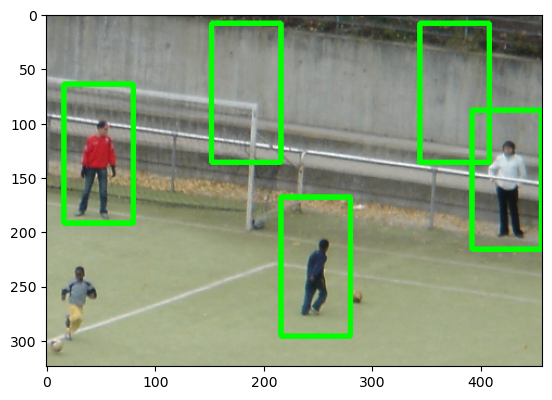

In [19]:

confidence_scores = np.array([0.9, 0.8, 0.6, 0.9, 0.8, 0.6, 0.9, 0.8, 0.6, 0.9, 0.8]) 
threshold = 0.5


# Apply non-maximum suppression
indices = cv2.dnn.NMSBoxes(bboxes=boxes, scores=confidence_scores, score_threshold=0.7, nms_threshold=threshold)
# Filter out the boxes based on the NMS result
filtered_boxes = [boxes[i] for i in indices.flatten()]
# Draw the filtered boxes on the image
for xmin, ymin, xmax, ymax in filtered_boxes:
    cv2.rectangle(img_copy, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# cv2.imshow("After NMS", img_copy)
# cv2.waitKey(0)
print("Filtered Boxes:", filtered_boxes)


plt.figure()
plt.imshow(img_copy)
plt.savefig('out.png')
plt.show()


array([[ 64,  88, 128, 216],
       [128, 136, 192, 264],
       [128, 144, 192, 272]])